# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Convert feature percentages to stdev
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime


NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)


# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
    # return map(lambda arr: 1 if arr[0] > 1 else 0, labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,4),arr), labels)

def convert_to_train(raw_dataset, offset=5):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        features.append(
            feature_dataset['Close']
                .map(lambda current: convert_to_percentage(latest_close, current))
                .tolist()
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Close'].iloc[i-2] / latest_close, # 2 day trade
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['Close'].iloc[i-4] / latest_close, # 4 day trade
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
def split_data(symbol):
    fetched = from_network(symbol).sort_values(by=['Date'],ascending=False)
    converted = convert_to_train(fetched)
    features = converted[0]
    labels = converted[1]
    training = [ # since we decide a model, use all data for training
        features[1:],
        labels[1:]
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    prediction = [
        features[:5],
        labels[:5],
    ]
    
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }


In [2]:

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[NUM_INPUT_NEURONS]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(48, activation=tf.nn.relu),
    layers.Dense(36, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(12, activation=tf.nn.relu),

      
#     layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(48, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(36, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(24, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer='sgd',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_3 (Dense)              (None, 36)                1764      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                888       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total para

In [3]:

#dataset = raw_dataset.copy()
#dataset = from_network('SPY').sort_values(by=['Date'],ascending=False)
# add function to cache fetch
QQQ = from_network('QQQ')
SPY = from_network('SPY')
XLK = from_network('XLK')
XLF = from_network('XLF')
XLE = from_network('XLE')
XLP = from_network('XLP')
XLV = from_network('XLV')
XLY = from_network('XLY')
XLI = from_network('XLI')
XLU = from_network('XLU')

#dataset = pd.concat([QQQ,SPY,XLK,XLF,XLE,XLP,XLV,XLY,XLI,XLU]).sort_values(by=['Date'],ascending=False)



In [16]:

prepped_data = map(split_data, [
    'QQQ',
    'SPY',
    'IWM',
    'VTI',
    'XLK',
    'XLF',
    'XLE',
    'XLP',
    'XLV',
    'XLY',
    'XLI',
    'XLU',
])


In [17]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


QQQ
SPY
IWM
VTI
XLK
XLF
XLE
XLP
XLV
XLY
XLI
XLU
0
4834
11210
15736
19997
24883
29769
34655
39541
44427
49313
54199


In [18]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
len(combined['training'][0])

59085

In [19]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


59085
11940
60


In [20]:
print train_data
print train_labels

[[ 0.         -0.00143802  0.00243364 ...  0.06543142  0.06128319
   0.06222345]
 [ 0.          0.0038661   0.00751133 ...  0.06263115  0.06357006
   0.06329389]
 [ 0.          0.00365937  0.00277223 ...  0.05993567  0.05965843
   0.06753165]
 ...
 [ 0.         -0.01635514 -0.02161122 ... -0.13434394 -0.14368973
  -0.12499815]
 [ 0.         -0.0051715  -0.0183908  ... -0.12528553 -0.10689473
  -0.11264368]
 [ 0.         -0.01315129 -0.01658001 ... -0.10119987 -0.10691924
  -0.08690688]]
[[1.0093]
 [0.9986]
 [1.0039]
 ...
 [0.9977]
 [0.9839]
 [0.9949]]


In [47]:
model.fit(
    train_data, train_labels,
    epochs=5, validation_split = 0.005, verbose=1,
    callbacks=[tensorboard]
)

history = model.fit(
    train_data, train_labels,
    epochs=200, validation_split = 0.005, verbose=1,
    callbacks=[tensorboard]
)

Train on 58789 samples, validate on 296 samples
Epoch 1/150
58789/58789 [==============================] - 3s 47us/step - loss: 5.3129e-05 - val_loss: 4.8547e-05
Epoch 2/150
58789/58789 [==============================] - 3s 47us/step - loss: 5.3104e-05 - val_loss: 4.8559e-05
Epoch 3/150
58789/58789 [==============================] - 3s 44us/step - loss: 5.3089e-05 - val_loss: 4.8554e-05
Epoch 4/150
58789/58789 [==============================] - 3s 44us/step - loss: 5.3051e-05 - val_loss: 4.8522e-05
Epoch 5/150
58789/58789 [==============================] - 3s 44us/step - loss: 5.3033e-05 - val_loss: 4.8502e-05
Epoch 6/150
58789/58789 [==============================] - 3s 44us/step - loss: 5.3014e-05 - val_loss: 4.8492e-05
Epoch 7/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.2986e-05 - val_loss: 4.8494e-05
Epoch 8/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.2974e-05 - val_loss: 4.8655e-05
Epoch 9/150
58789/58789 [===============

58789/58789 [==============================] - 3s 45us/step - loss: 5.1915e-05 - val_loss: 4.8010e-05
Epoch 72/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1902e-05 - val_loss: 4.8043e-05
Epoch 73/150
58789/58789 [==============================] - 3s 52us/step - loss: 5.1877e-05 - val_loss: 4.8000e-051s - loss: 5. - ETA: 0s - 
Epoch 74/150
58789/58789 [==============================] - 3s 52us/step - loss: 5.1883e-05 - val_loss: 4.7958e-05
Epoch 75/150
58789/58789 [==============================] - 3s 48us/step - loss: 5.1871e-05 - val_loss: 4.7997e-05
Epoch 76/150
58789/58789 [==============================] - 3s 49us/step - loss: 5.1849e-05 - val_loss: 4.7959e-05
Epoch 77/150
58789/58789 [==============================] - 3s 46us/step - loss: 5.1841e-05 - val_loss: 4.7947e-05
Epoch 78/150
58789/58789 [==============================] - 3s 48us/step - loss: 5.1830e-05 - val_loss: 4.7945e-05
Epoch 79/150
58789/58789 [==============================] - 3s 47us

58789/58789 [==============================] - 3s 47us/step - loss: 5.1169e-05 - val_loss: 4.7688e-05
Epoch 142/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1164e-05 - val_loss: 4.7656e-05
Epoch 143/150
58789/58789 [==============================] - 3s 47us/step - loss: 5.1152e-05 - val_loss: 4.7657e-05
Epoch 144/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1138e-05 - val_loss: 4.7655e-05
Epoch 145/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1133e-05 - val_loss: 4.7687e-05
Epoch 146/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1127e-05 - val_loss: 4.7692e-05
Epoch 147/150
58789/58789 [==============================] - 3s 44us/step - loss: 5.1117e-05 - val_loss: 4.7641e-05
Epoch 148/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.1110e-05 - val_loss: 4.7640e-05
Epoch 149/150
58789/58789 [==============================] - 3s 45us/step - loss: 5.10

In [48]:
outputs = model.predict(test_data)

In [49]:
print test_data[0]
print test_labels[0]
print outputs[0]

[ 0.          0.00285213  0.01091266  0.01977928  0.03131202  0.0710565
  0.0396825   0.04352681  0.05152528  0.05102924  0.05468745  0.11024305
  0.08500739  0.0557416   0.04185268  0.01773314  0.02387157  0.00124006
 -0.02368556 -0.02337552 -0.01444694 -0.01109876 -0.00062008 -0.03478423
 -0.02752978 -0.0685144  -0.05016119 -0.0425967  -0.04600693 -0.01339288
 -0.00998264  0.01283477  0.00564238  0.01314481 -0.0048363  -0.03856648
 -0.04222469 -0.02430554 -0.03218007 -0.03131202 -0.0634921  -0.08172128
 -0.08866569 -0.0555556  -0.0476191  -0.05022325 -0.06684027 -0.05295144
 -0.02876984 -0.01209075 -0.03335817 -0.06063987 -0.0251736  -0.07434279
 -0.07831104 -0.07279269 -0.07378468 -0.09926832 -0.09883434 -0.06777039
 -0.08085323 -0.05158735 -0.06479413 -0.11377732]
[0.9963]
[1.0070935]


In [50]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [51]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [52]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [53]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

,actual,signal,trade,entry_success,entry_failure,avoid_success,avoid_failure,success
0,0.9963,1.007094,1,0,1,0,0,0
1,1.0029,0.997021,0,0,0,0,1,1
2,1.0081,0.994398,0,0,0,0,1,1
3,1.0090,0.999603,0,0,0,0,1,1
4,1.0119,0.995621,0,0,0,0,1,1
5,1.0428,0.994062,0,0,0,0,1,1
6,0.9673,0.994644,0,0,0,1,0,1
7,1.0040,0.995939,0,0,0,0,1,1
8,1.0084,0.994749,0,0,0,0,1,1
9,0.9995,0.993876,0,0,0,1,0,1


In [54]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])

0.013263587143018878
0.011024579248785298
0.4308439770003506
0.43953834081849685


In [55]:
df['actual'].describe()

count    11940.00000
mean         1.00027
std          0.01017
min          0.94640
25%          0.99580
50%          1.00060
75%          1.00550
max          1.06240
Name: actual, dtype: float64

In [56]:
df['signal'].describe()

count    11940.000000
mean         1.000289
std          0.002431
min          0.987680
25%          0.998944
50%          1.000198
75%          1.001571
max          1.016850
Name: signal, dtype: float64

In [57]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


11940

Precision
0.538376325368

Recall
0.536847088528

Accuracy
0.284924623116

Non-loss events
9023
0.755695142379

Lose trades
2917
0.244304857621

Win trades
3402
0.284924623116

Missed opportunities
2935
0.24581239531

Bullets dodged
2590
0.216917922948


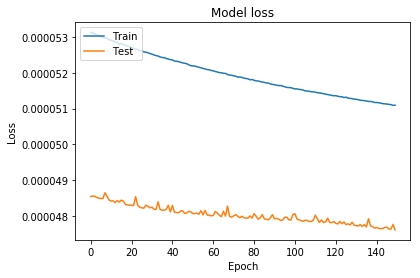

In [58]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [59]:
weights, biases = model.layers[0].get_weights()


In [60]:
#list(biases)

In [61]:
print "{} {}".format('SPY', model.predict(np.array(convert_to_train(SPY.copy(), 0)[0][:1])))
print "{} {}".format('QQQ', model.predict(np.array(convert_to_train(QQQ.copy(), 0)[0][:1])))
print "{} {}".format('XLE', model.predict(np.array(convert_to_train(XLE.copy(), 0)[0][:1])))
print "{} {}".format('XLF', model.predict(np.array(convert_to_train(XLF.copy(), 0)[0][:1])))
print "{} {}".format('XLK', model.predict(np.array(convert_to_train(XLK.copy(), 0)[0][:1])))
print "{} {}".format('XLP', model.predict(np.array(convert_to_train(XLP.copy(), 0)[0][:1])))
print "{} {}".format('XLV', model.predict(np.array(convert_to_train(XLV.copy(), 0)[0][:1])))
print "{} {}".format('XLU', model.predict(np.array(convert_to_train(XLU.copy(), 0)[0][:1])))
print "{} {}".format('XLY', model.predict(np.array(convert_to_train(XLY.copy(), 0)[0][:1])))
print "{} {}".format('XLI', model.predict(np.array(convert_to_train(XLI.copy(), 0)[0][:1])))


SPY [[0.99781907]]
QQQ [[0.99573797]]
XLE [[0.99497455]]
XLF [[1.0024977]]
XLK [[0.99753517]]
XLP [[1.0021014]]
XLV [[1.0002216]]
XLU [[0.999964]]
XLY [[1.0035602]]
XLI [[0.9998115]]
